In [1]:
import quantize
from utee import misc, quant, selector

import torch
import torchvision
import torchvision.transforms as transforms

import torch.backends.cudnn as cudnn
cudnn.benchmark = True
from collections import OrderedDict

import time
import os

In [2]:
class Args:
    def __init__(self,
                 type='cifar10',
                 quant_method='linear',
                 batch_size=100,
                 gpu=None,
                 ngpu=8,
                 seed=117,
                 model_root='~/.torch/models/',
                 data_root='/data/public_dataset/pytorch/',
                 logdir='log/default',
                 input_size=224,
                 n_sample=20,
                 param_bits=8,
                 bn_bits=32,
                 fwd_bits=8,
                 overflow_rate=0.0,
                 lr=0.1):
        self.type = type
        self.quant_method = quant_method
        self.batch_size = batch_size
        self.gpu = gpu
        self.ngpu = ngpu
        self.seed = seed
        self.model_root = model_root
        self.data_root = data_root
        self.logdir = logdir
        self.input_size = input_size
        self.n_sample = n_sample
        self.param_bits = param_bits
        self.bn_bits = bn_bits
        self.fwd_bits = fwd_bits
        self.overflow_rate = overflow_rate
        self.lr = lr
        
        self.gpu = misc.auto_select_gpu(utility_bound=0, num_gpu=self.ngpu, selected_gpus=self.gpu)
        self.ngpu = len(self.gpu)
        misc.ensure_dir(self.logdir)
        self.model_root = misc.expand_user(self.model_root)
        self.data_root = misc.expand_user(self.data_root)
        self.input_size = 299 if 'inception' in self.type else self.input_size
        assert self.quant_method in ['linear', 'minmax', 'log', 'tanh']
        print("=================FLAGS==================")
        for k, v in self.__dict__.items():
            print('{}: {}'.format(k, v))
        print("========================================")

In [3]:
torch.cuda.is_available()

True

In [4]:
def get_optimizer(network, args):
    optimizer = torch.optim.SGD(network.parameters(),
                                lr=args.lr)    

    scheduler = None
    return optimizer, scheduler

In [5]:
class Loss_Calculator(object):
    def __init__(self):
        self.criterion = torch.nn.CrossEntropyLoss()        
        self.loss_seq = []
    
    def calc_loss(self, output, target):
        loss = self.criterion(output, target)        
        self.loss_seq.append(loss.item())
        return loss

    def get_loss_log(self, length=100):
        # get recent average loss values
        if len(self.loss_seq) < length:
            length = len(self.loss_seq)
        return sum(self.loss_seq[-length:])/length
    
class AverageMeter(object):    
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [6]:
def get_transformer(data_set, imsize=None, cropsize=None, crop_padding=None, hflip=None):
    transformers = [] 
    if imsize:
        transformers.append(transforms.Resize(imsize))
    if cropsize:
        ## https://github.com/kuangliu/pytorch-cifar
        transformers.append(transforms.RandomCrop(cropsize, padding=crop_padding))
    if hflip:
        transformers.append(transforms.RandomHorizontalFlip(hflip))

    transformers.append(transforms.ToTensor())
#     transformers.append(get_normalizer(data_set))
    
    return transforms.Compose(transformers)

def get_normalizer(data_set, inverse=False):
    if data_set == 'CIFAR10':
        MEAN = (0.4914, 0.4822, 0.4465)
        STD = (0.2023, 0.1994, 0.2010)

    elif data_set == 'CIFAR100':
        MEAN = (0.5071, 0.4867, 0.4408)
        STD = (0.2675, 0.2565, 0.2761)

    else:
        raise RuntimeError("Not expected data flag !!!")

    if inverse:
        MEAN = [-mean/std for mean, std in zip(MEAN, STD)]
        STD = [1/std for std in STD]

    return transforms.Normalize(MEAN, STD)

In [7]:
def get_data_set(args, train_flag=True):
    if train_flag:
        data_set = torchvision.datasets.__dict__['CIFAR10'](root=args.data_root, train=True, 
#                                        transform=get_transformer('CIFAR10', None, 32, 4, 0.5), 
                                                            transform=get_transformer('CIFAR10', None, None, None, None), 
                                                            download=True)   
    return data_set

In [8]:
torch.cuda.is_available()

True

In [9]:
def train_network(args, network, train_ds, val_ds):
    optimizer, scheduler = get_optimizer(network, args)
    loss_calculator = Loss_Calculator()
#     data_set = get_data_set(args, train_flag=True)
    device = torch.device("cuda" if args.ngpu >= 0 else "cpu")

    if os.path.exists("check_point.pth"):
        print('Loading checkpointed model')
        network.load_state_dict(torch.load("check_point.pth"))
    else:
        print('No checkpointed model, training from scratch')
        for epoch in range(1, 25):
    #         data_loader = torch.utils.data.DataLoader(data_set, batch_size=args.batch_size, shuffle=True)
            train_step(network, train_ds, val_ds, loss_calculator, optimizer, device, epoch)

            if scheduler is not None:
                scheduler.step()

            torch.save(network.state_dict(), "check_point.pth")
        
    return network

In [10]:
def train_step(network, data_loader, test_loader, loss_calculator, optimizer, device, epoch, print_freq=100):
    network.train()
    network.to(device)
    # set benchmark flag to faster runtime
    torch.backends.cudnn.benchmark = True
        
    data_time = AverageMeter()
    loss_time = AverageMeter()    
    forward_time = AverageMeter()
    backward_time = AverageMeter()
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    tic = time.time()
    for iteration, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - tic)
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        tic = time.time()
        outputs = network(inputs)
        forward_time.update(time.time() - tic)
        
        tic = time.time()
        loss = loss_calculator.calc_loss(outputs, targets)
        loss_time.update(time.time() - tic)
        
        tic = time.time()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        backward_time.update(time.time() - tic)
        tic = time.time()
      
    acc1, acc5 = misc.eval_model(network, test_loader, ngpu=args.ngpu)
    logs_ = 'Epoch [%d], '%epoch
    logs_ += 'Data(s): %2.3f, Loss(s): %2.3f, '%(data_time.avg, loss_time.avg)
    #             logs_ += 'Forward(s): %2.3f, Backward(s): %2.3f, '%(forward_time.avg, backward_time.avg)
    logs_ += 'Top1: %2.4f, Top5: %2.4f, '%(acc1, acc5)
    logs_ += 'Loss: %2.3f'%loss_calculator.get_loss_log()
    print(logs_)  
    return None

In [11]:
def acc(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
            
    return correct / total

In [12]:
def accuracy(output, target, topk=(1,)):
    """
        Computes the precision@k for the specified values of k
        ref: https://github.com/chengyangfu/pytorch-vgg-cifar10
    """
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [13]:
def run(args):
    assert torch.cuda.is_available(), 'no cuda'
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)

    # load model and dataset fetcher
    model_raw, ds_fetcher, is_imagenet = selector.select(args.type, model_root=args.model_root)
    args.ngpu = args.ngpu if is_imagenet else 1
    
    val_ds = ds_fetcher(args.batch_size, data_root=args.data_root, train=False, input_size=args.input_size)
    train_ds = ds_fetcher(args.batch_size, data_root=args.data_root, train=True, val=False, input_size=args.input_size)
    model_raw = train_network(args, model_raw, train_ds, val_ds)
    
#     '''
    # quantize parameters
    if args.param_bits < 32:
        state_dict = model_raw.state_dict()
        state_dict_quant = OrderedDict()
        sf_dict = OrderedDict()
        for k, v in state_dict.items():
            if 'running' in k:
                if args.bn_bits >=32:
                    print("Ignoring {}".format(k))
                    state_dict_quant[k] = v
                    continue
                else:
                    bits = args.bn_bits
            else:
                bits = args.param_bits

            if args.quant_method == 'linear':
                sf = bits - 1. - quant.compute_integral_part(v, overflow_rate=args.overflow_rate)
                v_quant  = quant.linear_quantize(v, sf, bits=bits)
            elif args.quant_method == 'log':
                v_quant = quant.log_minmax_quantize(v, bits=bits)
            elif args.quant_method == 'minmax':
                v_quant = quant.min_max_quantize(v, bits=bits)
            else:
                v_quant = quant.tanh_quantize(v, bits=bits)
            state_dict_quant[k] = v_quant
            print(k, bits)
        model_raw.load_state_dict(state_dict_quant)

    # quantize forward activation
    if args.fwd_bits < 32:
        model_raw = quant.duplicate_model_with_quant(model_raw, bits=args.fwd_bits, overflow_rate=args.overflow_rate,
                                                     counter=args.n_sample, type=args.quant_method)
        print(model_raw)
        val_ds_tmp = ds_fetcher(10, data_root=args.data_root, train=False, input_size=args.input_size)
        misc.eval_model(model_raw, val_ds_tmp, ngpu=1, n_sample=args.n_sample, is_imagenet=is_imagenet)

    # eval model
    val_ds = ds_fetcher(args.batch_size, data_root=args.data_root, train=False, input_size=args.input_size)
    acc1, acc5 = misc.eval_model(model_raw, val_ds, ngpu=args.ngpu, is_imagenet=is_imagenet)

    # print sf
    print(model_raw)
    res_str = "type={}, quant_method={}, param_bits={}, bn_bits={}, fwd_bits={}, overflow_rate={}, acc1={:.4f}, acc5={:.4f}".format(
        args.type, args.quant_method, args.param_bits, args.bn_bits, args.fwd_bits, args.overflow_rate, acc1, acc5)
    print(res_str)
    with open('acc1_acc5.txt', 'a') as f:
        f.write(res_str + '\n')
    return model_raw
# '''

In [14]:
args = Args(type='vgg16', param_bits=32, fwd_bits=32, bn_bits=32, data_root='/tmp/public_dataset/pytorch', ngpu=1)
run(args)

Setting GPU: ['0']
Building and initializing vgg16 parameters


=================FLAGS==================
type: vgg16
quant_method: linear
batch_size: 100
gpu: ['0']
ngpu: 1
seed: 117
model_root: /home/rg3387/.torch/models
data_root: /tmp/public_dataset/pytorch
logdir: log/default
input_size: 224
n_sample: 20
param_bits: 32
bn_bits: 32
fwd_bits: 32
overflow_rate: 0.0
lr: 0.1


---------------
{'model_root': '/home/rg3387/.torch/models'}
---------------


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Loading checkpointed model
Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [00:02<00:00, 47.22it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
print(f"Original Model Size = {os.path.getsize('check_point.pth') / (1e6) :.1f} MB")

Original Model Size = 134.6 MB


In [17]:
args = Args(type='vgg16', param_bits=16, fwd_bits=16, bn_bits=16, data_root='/tmp/public_dataset/pytorch', ngpu=1)
quantized_model = run(args)

Setting GPU: ['0']
Building and initializing vgg16 parameters


=================FLAGS==================
type: vgg16
quant_method: linear
batch_size: 100
gpu: ['0']
ngpu: 1
seed: 117
model_root: /home/rg3387/.torch/models
data_root: /tmp/public_dataset/pytorch
logdir: log/default
input_size: 224
n_sample: 20
param_bits: 16
bn_bits: 16
fwd_bits: 16
overflow_rate: 0.0
lr: 0.1


---------------
{'model_root': '/home/rg3387/.torch/models'}
---------------


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Loading checkpointed model
features.0.weight 16
features.0.bias 16
features.2.weight 16
features.2.bias 16
features.5.weight 16
features.5.bias 16
features.7.weight 16
features.7.bias 16
features.10.weight 16
features.10.bias 16
features.12.weight 16
features.12.bias 16
features.14.weight 16
features.14.bias 16
features.17.weight 16
features.17.bias 16
features.19.weight 16
features.19.bias 16
features.21.weight 16
features.21.bias 16
features.24.weight 16
features.24.bias 16
features.26.weight 16
features.26.bias 16
features.28.weight 16
features.28.bias 16
classifier.0.weight 16
classifier.0.bias 16
classifier.1.weight 16
classifier.1.bias 16
classifier.2.weight 16
classifier.2.bias 16
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuan

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 19/20 [00:00<00:00, 58.71it/s]


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [00:01<00:00, 49.81it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuant(sf=12, bits=16, overflow_rate=0.000, counter=0)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2_linear_quant): LinearQuant(sf=10, bits=16, overflow_rate=0.000, counter=0)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5_linear_quant): LinearQuant(sf=10, bits=16, overflow_rate=0.000, counter=0)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7_linear_quant): LinearQuant(sf=10, bits=16, overflow_rate=0.000, counter=0)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1

In [18]:
torch.save(quantized_model.state_dict(), "quantized_check_point.pth")

In [19]:
print(f"Quantized Model Size = {os.path.getsize('quantized_check_point.pth') / (1e6) :.1f} MB")

Quantized Model Size = 134.6 MB


In [20]:
args = Args(type='vgg16', param_bits=8, fwd_bits=8, bn_bits=8, data_root='/tmp/public_dataset/pytorch', ngpu=1)
quantized_model = run(args)

Setting GPU: ['0']
Building and initializing vgg16 parameters


=================FLAGS==================
type: vgg16
quant_method: linear
batch_size: 100
gpu: ['0']
ngpu: 1
seed: 117
model_root: /home/rg3387/.torch/models
data_root: /tmp/public_dataset/pytorch
logdir: log/default
input_size: 224
n_sample: 20
param_bits: 8
bn_bits: 8
fwd_bits: 8
overflow_rate: 0.0
lr: 0.1


---------------
{'model_root': '/home/rg3387/.torch/models'}
---------------


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Loading checkpointed model
features.0.weight 8
features.0.bias 8
features.2.weight 8
features.2.bias 8
features.5.weight 8
features.5.bias 8
features.7.weight 8
features.7.bias 8
features.10.weight 8
features.10.bias 8
features.12.weight 8
features.12.bias 8
features.14.weight 8
features.14.bias 8
features.17.weight 8
features.17.bias 8
features.19.weight 8
features.19.bias 8
features.21.weight 8
features.21.bias 8
features.24.weight 8
features.24.bias 8
features.26.weight 8
features.26.bias 8
features.28.weight 8
features.28.bias 8
classifier.0.weight 8
classifier.0.bias 8
classifier.1.weight 8
classifier.1.bias 8
classifier.2.weight 8
classifier.2.bias 8
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuant(sf=None, bits=8, overflow_rate

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 19/20 [00:00<00:00, 76.73it/s]


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [00:02<00:00, 48.69it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuant(sf=4, bits=8, overflow_rate=0.000, counter=0)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2_linear_quant): LinearQuant(sf=2, bits=8, overflow_rate=0.000, counter=0)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5_linear_quant): LinearQuant(sf=2, bits=8, overflow_rate=0.000, counter=0)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7_linear_quant): LinearQuant(sf=2, bits=8, overflow_rate=0.000, counter=0)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddi

In [21]:
torch.save(quantized_model.state_dict(), "quantized_check_point.pth")

In [22]:
print(f"Quantized Model Size = {os.path.getsize('quantized_check_point.pth') / (1e6) :.1f} MB")

Quantized Model Size = 134.6 MB


In [23]:
args = Args(type='vgg16', param_bits=4, fwd_bits=4, bn_bits=4, data_root='/tmp/public_dataset/pytorch', ngpu=1)
quantized_model = run(args)

Setting GPU: ['0']
Building and initializing vgg16 parameters


=================FLAGS==================
type: vgg16
quant_method: linear
batch_size: 100
gpu: ['0']
ngpu: 1
seed: 117
model_root: /home/rg3387/.torch/models
data_root: /tmp/public_dataset/pytorch
logdir: log/default
input_size: 224
n_sample: 20
param_bits: 4
bn_bits: 4
fwd_bits: 4
overflow_rate: 0.0
lr: 0.1


---------------
{'model_root': '/home/rg3387/.torch/models'}
---------------


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified
Loading checkpointed model
features.0.weight 4
features.0.bias 4
features.2.weight 4
features.2.bias 4
features.5.weight 4
features.5.bias 4
features.7.weight 4
features.7.bias 4
features.10.weight 4
features.10.bias 4
features.12.weight 4
features.12.bias 4
features.14.weight 4
features.14.bias 4
features.17.weight 4
features.17.bias 4
features.19.weight 4
features.19.bias 4
features.21.weight 4
features.21.bias 4
features.24.weight 4
features.24.bias 4
features.26.weight 4
features.26.bias 4
features.28.weight 4
features.28.bias 4
classifier.0.weight 4
classifier.0.bias 4
classifier.1.weight 4
classifier.1.bias 4
classifier.2.weight 4
classifier.2.bias 4
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuant(sf=None, bits=4, overflow_rate

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 19/20 [00:00<00:00, 76.69it/s]


Building CIFAR-10 data loader with 1 workers
Files already downloaded and verified


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [00:02<00:00, 46.67it/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (0_linear_quant): LinearQuant(sf=0, bits=4, overflow_rate=0.000, counter=0)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2_linear_quant): LinearQuant(sf=-2, bits=4, overflow_rate=0.000, counter=0)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5_linear_quant): LinearQuant(sf=-2, bits=4, overflow_rate=0.000, counter=0)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7_linear_quant): LinearQuant(sf=-2, bits=4, overflow_rate=0.000, counter=0)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

In [24]:
torch.save(quantized_model.state_dict(), "quantized_check_point.pth")

In [25]:
print(f"Quantized Model Size = {os.path.getsize('quantized_check_point.pth') / (1e6) :.1f} MB")

Quantized Model Size = 134.6 MB


In [ ]:
type=vgg16, quant_method=linear, param_bits=32, bn_bits=32, fwd_bits=32, overflow_rate=0.0, acc1=0.8584, acc5=0.9920
type=vgg16, quant_method=linear, param_bits=16, bn_bits=16, fwd_bits=16, overflow_rate=0.0, acc1=0.8583, acc5=0.9920
type=vgg16, quant_method=linear, param_bits=8, bn_bits=8, fwd_bits=8, overflow_rate=0.0, acc1=0.8566, acc5=0.9920
type=vgg16, quant_method=linear, param_bits=4, bn_bits=4, fwd_bits=4, overflow_rate=0.0, acc1=0.3260, acc5=0.6766

In [26]:
top1 = [0.8584, 0.8583, 0.8566, 0.3260]
top5 = [0.9920, 0.9920, 0.9920, 0.6766]

In [30]:
import matplotlib.pyplot as plt
import numpy as np

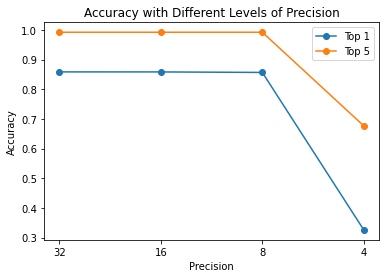

In [41]:
plt.plot(np.arange(4), top1, marker='o', label='Top 1')
plt.plot(np.arange(4), top5, marker='o', label='Top 5')
plt.xticks(np.arange(4), [32, 16, 8, 4])
plt.xlabel('Precision')
plt.ylabel('Accuracy')
plt.title('Accuracy with Different Levels of Precision')
plt.legend()
plt.show()